In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from fiona.crs import from_epsg
from shapely.geometry import Point

from scipy.ndimage.filters import generic_filter as gen_f, gaussian_filter as gaus_f

import sqlite3

import pytz
import datetime

In [23]:
ehp_bbox = {"xmin" : 362000, "xmax" : 363000, "ymin" : 569600, "ymax" : 570300}
hp_bbox = {"xmin" : 359250, "xmax" : 364000, "ymin" : 566750, "ymax" : 571000}

streets = gpd.read_file("streets_lw.geojson")

def pretty_map(gdf, column, label, 
               vmin, vmax, vsteps, vscale = 1, 
               bbox = hp_bbox, streets = streets,
               loc = [0.75, 0.85, 0.2, 0.015]):
    
    fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

    cmap = discretize_colormap("viridis", vsteps)
    gdf.plot(column = column, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax)

    streets.plot(color  = "w", ax = ax, lw = streets.highway_thickness / 4)

    ax.set_xlim(bbox["xmin"], bbox["xmax"])
    ax.set_ylim(bbox["ymin"], bbox["ymax"])

    ax.set_facecolor("k")

    map_format(ax)

    add_cmap(fig, cmap, 
             text = label, location = loc, 
             ticks = list(np.linspace(vmin, vmax, vsteps / vscale + 1)),
             invert_colors = True, vmin = vmin, vmax = vmax)
    
    return ax

def pretty_hist(gdf, label, 
                vmin, vmax, vsteps, vscale = 1, cmap = "hot", radius = 0,
                bbox = hp_bbox, loc = [0.7, 0.20, 0.2, 0.015], 
                return_hist = False):

    fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

    H, xedges, yedges = \
      np.histogram2d(gdf.geometry.x, gdf.geometry.y,
                     bins = (np.arange(bbox["xmin"], bbox["xmax"] + 0.01, 10),
                             np.arange(bbox["ymin"], bbox["ymax"] + 0.01, 10)))

    if radius: H = gaus_f(H, sigma = radius)

    H = np.ma.masked_array(H, mask = H < 0.01)

    X, Y = np.meshgrid(xedges, yedges)

    norm = Normalize(vmin = vmin, vmax = vmax)

    cmap = truncate_colormap(cm.get_cmap(cmap), 0.025, 1)
    cmap = discretize_colormap(cmap, vsteps)
    cmap.set_bad('k', 1)

    im = ax.pcolormesh(X, Y, H.T, cmap = cmap, norm = norm)

    map_format(ax)

    add_cmap(fig, cmap, 
             text = label, location = loc, 
             ticks = list(np.linspace(vmin, vmax, min(5, vsteps/2 + 1))),
             invert_colors = True, vmin = vmin, vmax = vmax)
    
    if return_hist: 
        plt.close("all")
        return H, xedges, yedges
    
    return ax


def bin_by_tract(H, xedges, yedges):
    
    xmod = H.shape[0]
    xctr = ((xedges[:-1] + xedges[1:]) / 2)
    yctr = ((yedges[:-1] + yedges[1:]) / 2)
    
    gs, vals, X, Y = [], [], [], []
    for b in range(H.size):
        
        if H.mask[b % xmod, b // xmod]: continue
            
        gs.  append(Point(xctr[b  % xmod], 
                          yctr[b // xmod]))
        
        X.append(b  % xmod)
        Y.append(b // xmod)
        vals.append(H[b % xmod, b // xmod])
    
    gs = gpd.GeoSeries(gs, crs = from_epsg(3528))
    
    gdf = gpd.GeoDataFrame(data = {"nets" : vals, "X" : X, "Y" : Y}, geometry = gs, crs = from_epsg)
    
    con = get_con()
    tracts = gpd.read_postgis("SELECT geoid, ST_Transform(geom, 3528) geom "
                              "FROM census_tracts_2018 WHERE state = 17 AND county = 31;",
                              con = con, crs = from_epsg(3528))

    acs = pd.read_csv("data/acs_2018.csv.gz")
    acs.drop(["state", "county", "tract"], axis = 1, inplace = True)
    
    tracts = tracts.merge(acs)

    tract_nets = gpd.sjoin(tracts, gdf, op = "contains")
    tracts = tracts.merge(tract_nets.groupby("geoid").nets.sum().reset_index())
    
    return tracts
    

In [3]:
! sqlite3 wiglewifi.sqlite <<< ".schema"

CREATE TABLE android_metadata (locale TEXT);
CREATE TABLE network ( bssid text primary key not null,ssid text not null,frequency int not null,capabilities text not null,lasttime long not null,lastlat double not null,lastlon double not null,type text not null default 'W',bestlevel integer not null default 0,bestlat double not null default 0,bestlon double not null default 0);
CREATE TABLE location ( _id integer primary key autoincrement,bssid text not null,level integer not null,lat double not null,lon double not null,altitude double not null,accuracy float not null,time long not null,external integer not null default 0);
CREATE TABLE sqlite_sequence(name,seq);
CREATE TABLE route ( _id integer primary key autoincrement,run_id integer not null,wifi_visible integer not null default 0,cell_visible integer not null default 0,bt_visible integer not null default 0,lat double not null,lon double not null,altitude double not null,accuracy float not null,time long not null);


OK, so we have to go to source to understand a few of these, but: 
* [Network types](https://github.com/wiglenet/wigle-wifi-wardriving/blob/master/wiglewifiwardriving/src/main/java/net/wigle/wigleandroid/model/NetworkType.java): {"W" : "Wifi" , "B" : "Bluetooth", "E" : "BLE", "G" : "GSM", "C" : "CDMA", "L" : "LTE", "D" : "WCDM", "N" : "NFC"} 

In [4]:
con   = sqlite3.connect("wiglewifi.sqlite")

net_sql = """
SELECT 
  bssid, ssid, frequency AS freq, bestlevel AS level, bestlat AS lat, bestlon AS lon, type
FROM network WHERE type = 'W';
"""

loc_sql = """
SELECT bssid, level, lat, lon, accuracy AS acc, time 
FROM location
WHERE time > 0;
"""

route_sql = """
SELECT
  wifi_visible AS n_wifi, cell_visible AS n_cell, bt_visible as n_bt, 
  lat, lon, accuracy AS acc, time 
FROM route;
"""

net   = pd.read_sql(net_sql, con)
loc   = pd.read_sql(loc_sql, con)
route = pd.read_sql(route_sql, con)

for df in [loc, route]:
    df.time = pd.to_datetime(df.time, unit='ms', origin='unix')\
                .dt.tz_localize('utc').dt.tz_convert(pytz.timezone('US/Central'))
    
net   = gpd.GeoDataFrame(data = net,   crs = from_epsg(3528), geometry = \
                         gpd.GeoSeries([Point(xy) for xy in net[["lon", "lat"]].values], 
                                       crs = from_epsg(4326)).to_crs(epsg = 3528))
  
loc   = gpd.GeoDataFrame(data = loc,   crs = from_epsg(3528), geometry = \
                         gpd.GeoSeries([Point(xy) for xy in loc[["lon", "lat"]].values], 
                                       crs = from_epsg(4326)).to_crs(epsg = 3528))

route = gpd.GeoDataFrame(data = route, crs = from_epsg(3528), geometry = \
                         gpd.GeoSeries([Point(xy) for xy in route[["lon", "lat"]].values], 
                                       crs = from_epsg(4326)).to_crs(epsg = 3528))

/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


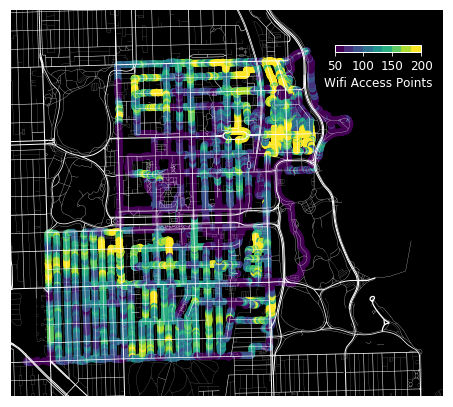

In [5]:
pretty_map(gdf = route, column = "n_wifi", label = "Wifi Access Points", 
           vmin = 50, vmax = 200, vsteps = 9, vscale = 3)

/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


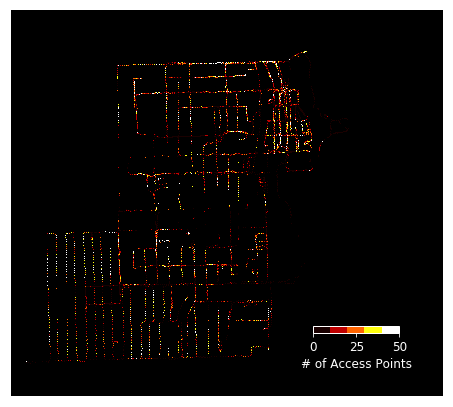

In [6]:
pretty_hist(net, "# of Access Points", vmin = 0, vmax = 50, vsteps = 5)

/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


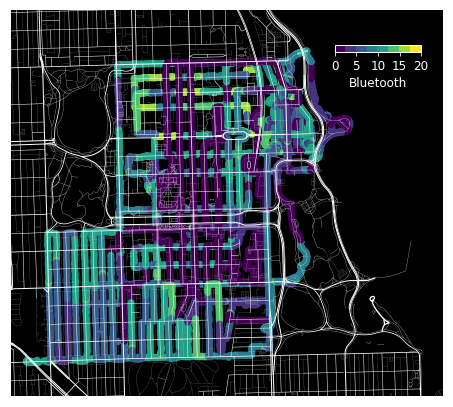

In [7]:
pretty_map(gdf = route, column = "n_bt", label = "Bluetooth", 
           vmin = 0, vmax = 20, vsteps = 8, vscale = 2)

Interesting to do a time series of this, at the park...

The receiver on my old phone clearly truncates at 200 devices.

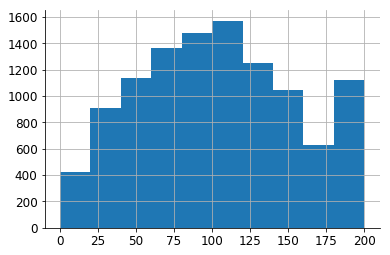

In [8]:
route.n_wifi.hist()

For my home network, it shows up at slightly weird intervals.  Not clear exactly when things get written to the DB.

In [9]:
loc.query("bssid == 'c0:a0:0d:cb:8c:5b'")

,bssid,level,lat,lon,acc,time,geometry
5,c0:a0:0d:cb:8c:5b,-68,41.800201,-87.583357,31.0,2020-06-09 12:54:25-05:00,POINT (362328.7509360176 570183.1069724341)
119,c0:a0:0d:cb:8c:5b,-63,41.800028,-87.583521,17.0,2020-06-09 12:54:50-05:00,POINT (362315.2464366742 570163.7718702783)
601,c0:a0:0d:cb:8c:5b,-70,41.799309,-87.583799,240.0,2020-06-09 13:54:52-05:00,POINT (362292.893520099 570083.7120588409)
9181,c0:a0:0d:cb:8c:5b,-78,41.799426,-87.584755,4.0,2020-06-09 15:48:50-05:00,POINT (362213.3514684055 570096.0703495709)
9423,c0:a0:0d:cb:8c:5b,-57,41.799412,-87.584499,13.0,2020-06-09 16:54:05-05:00,POINT (362234.5845027887 570094.6935642357)
9557,c0:a0:0d:cb:8c:5b,-52,41.799311,-87.583889,106.0,2020-06-09 17:16:59-05:00,POINT (362285.4007668471 570083.8888730024)
30752,c0:a0:0d:cb:8c:5b,-64,41.799185,-87.584745,24.0,2020-06-09 18:30:07-05:00,POINT (362214.3939964121 570069.3178612313)
46766,c0:a0:0d:cb:8c:5b,-91,41.799298,-87.584707,16.0,2020-06-10 15:30:09-05:00,POINT (362217.4145056517 570081.8102389249)
46815,c0:a0:0d:cb:8c:5b,-69,41.799306,-87.584679,43.0,2020-06-10 15:33:57-05:00,POINT (362219.723003466 570082.816700552)
46862,c0:a0:0d:cb:8c:5b,-41,41.799634,-87.584263,21.0,2020-06-10 15:34:35-05:00,POINT (362254.0144258707 570119.4895471352)


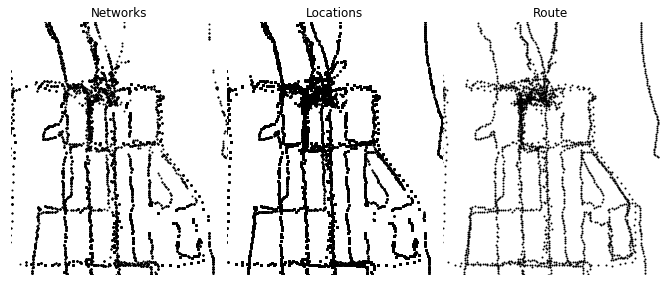

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (9, 9), 
                       subplot_kw = {"aspect" : 1})

bbox = {"xmin" : 362000, "xmax" : 362600, "ymin" : 569600, "ymax" : 570300}

for i, df, label in zip([0, 1, 2], [net, loc, route],
                        ["Networks", "Locations", "Route"]): 
    df.plot(ax = ax[i], markersize = 1, color = "k")

    ax[i].set_title(label)
    ax[i].set_xlim(bbox["xmin"], bbox["xmax"])
    ax[i].set_ylim(bbox["ymin"], bbox["ymax"])
    map_format(ax[i])

So clearly, route is ephemeral, but we should be able to get the count at a location by aggregating locations, on time -- right??

In [11]:
num_loc = loc[loc.bssid.isin(net.bssid)].copy()
num_loc = num_loc.groupby("time").bssid.count().reset_index(name = "n_wifi")
geo_loc = loc[["time", "geometry"]].sort_values(by = "time").drop_duplicates("time", keep = "first")

geo_loc = geo_loc.merge(num_loc)

/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


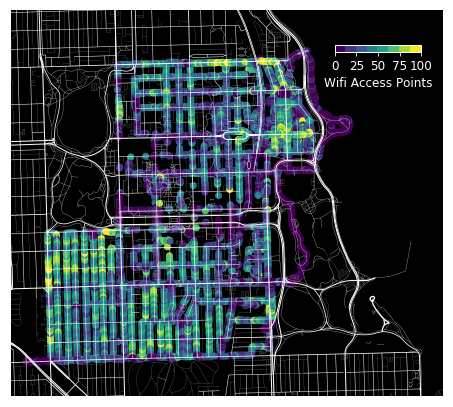

In [12]:
pretty_map(gdf = geo_loc, column = "n_wifi", label = "Wifi Access Points", 
           vmin = 0, vmax = 100, vsteps = 8, vscale = 2)

That doesn't look right -- it was smooth above, and here there's a lot of variation in the number of access points along a path.

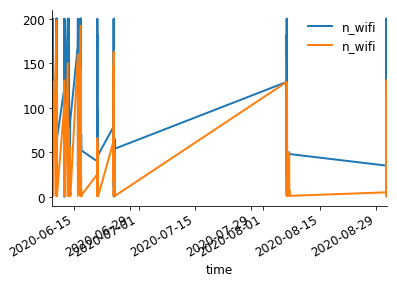

In [13]:
fig, ax = plt.subplots()

route  [["time", "n_wifi"]].plot(x = "time", y = "n_wifi", ax = ax)
num_loc[["time", "n_wifi"]].plot(x = "time", y = "n_wifi", ax = ax)

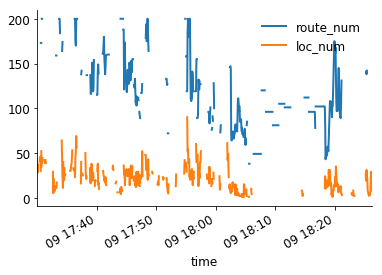

In [14]:
route_num = pd.merge(route  [["time", "n_wifi"]].rename(columns = {"n_wifi" : "route_num"}),
                     num_loc[["time", "n_wifi"]].rename(columns = {"n_wifi" : "loc_num"}), 
                     how = "outer").set_index("time")

route_num = route_num[(route_num.index > pd.Timestamp("2020-06-09 17:30", tz = "US/Central")) & 
                      (route_num.index < pd.Timestamp("2020-06-09 18:30", tz = "US/Central"))]

route_num.plot()

In [15]:
route_num.head(20)

,route_num,loc_num
time,,
2020-06-09 17:30:01-05:00,200.0,NaN
2020-06-09 17:30:06-05:00,176.0,28.0
2020-06-09 17:30:11-05:00,184.0,NaN
2020-06-09 17:30:15-05:00,185.0,NaN
2020-06-09 17:30:19-05:00,181.0,NaN
2020-06-09 17:30:23-05:00,176.0,NaN
2020-06-09 17:30:27-05:00,190.0,NaN
2020-06-09 17:30:34-05:00,178.0,46.0
2020-06-09 17:30:39-05:00,173.0,NaN


In [16]:
list(route_num[~route_num.route_num.isna()].index.strftime("%H:%M:%S").unique())[:20]

['17:30:01',
 '17:30:06',
 '17:30:11',
 '17:30:15',
 '17:30:19',
 '17:30:23',
 '17:30:27',
 '17:30:34',
 '17:30:39',
 '17:30:43',
 '17:30:48',
 '17:30:52',
 '17:30:58',
 '17:31:02',
 '17:31:06',
 '17:31:10',
 '17:31:15',
 '17:31:24',
 '17:31:30',
 '17:31:34']

In [17]:
list(route_num[~route_num.loc_num.isna()].index.strftime("%H:%M:%S").unique())[:20]

['17:30:06',
 '17:30:34',
 '17:30:43',
 '17:30:52',
 '17:32:45',
 '17:33:16',
 '17:33:48',
 '17:34:13',
 '17:34:17',
 '17:35:39',
 '17:36:19',
 '17:36:23',
 '17:36:27',
 '17:36:31',
 '17:36:35',
 '17:36:39',
 '17:37:25',
 '17:38:57',
 '17:39:01',
 '17:39:05']

So clearly not, and it is not clear to me how this aggregation works -- routes are every five seconds or so, whereas locations are a few times per minute..  To ask.

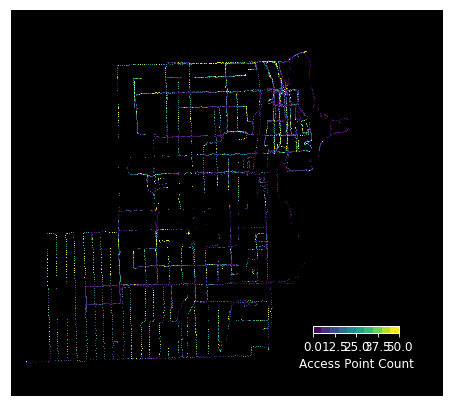

In [18]:
ax = pretty_hist(net, "Access Point Count", vmin = 0, vmax = 50, vsteps = 10, vscale = 2, cmap = "viridis")

ax.figure.savefig("n_access_points.pdf", bbox_inches = "tight", pad_inches = 0.1)

In [19]:
ax.figure.savefig("n_access_points.png", facecolor = "k", edgecolor='none', 
                  bbox_inches='tight', pad_inches=0.025, linewidth = 3, dpi = 300)

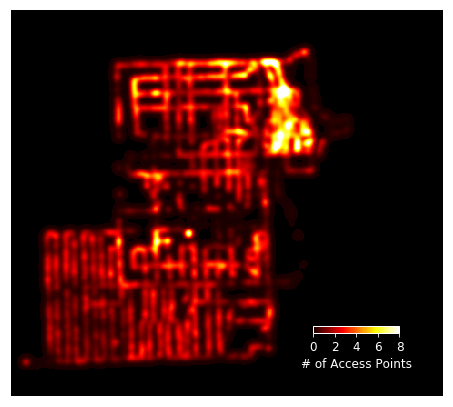

In [20]:
ax = pretty_hist(net, "# of Access Points", radius = 3, vmin = 0, vmax = 8, vsteps = 80)

ax.figure.savefig("n_access_points_gf.png", facecolor = "k", edgecolor='none', 
                  bbox_inches='tight', pad_inches=0.025, linewidth = 3, dpi = 300)

### Now finally, let's compare these to Census numbers, to see if there's any consistent bias...

In [21]:
H, xedges, yedges = pretty_hist(net, "# of Access Points", 
                                radius = 3, vmin = 0, vmax = 8, vsteps = 80, return_hist = True)

In [24]:
tracts = bin_by_tract(H, xedges, yedges)

tracts = tracts.query("nets > 1600").copy()

tracts["Broadband Subscriptions"] = tracts["Broadband"] * tracts["Total Households"]

totals = tracts.sum()
slope = totals["nets"] / totals["Broadband Subscriptions"]

tracts["nets_prop"]  = tracts["Broadband Subscriptions"] * slope
tracts["nets_resid"] = tracts["nets"] - tracts["nets_prop"]

In [25]:
tracts_scalars = tracts[[c for c in tracts.columns if c != "geom"]].copy()

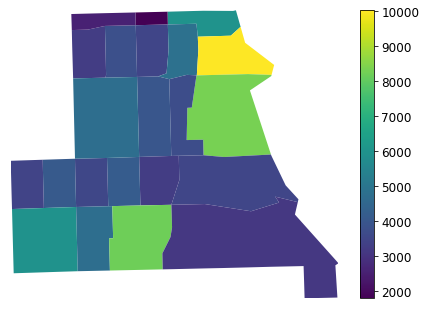

In [26]:
map_format(tracts.plot(column = "nets", legend = True))

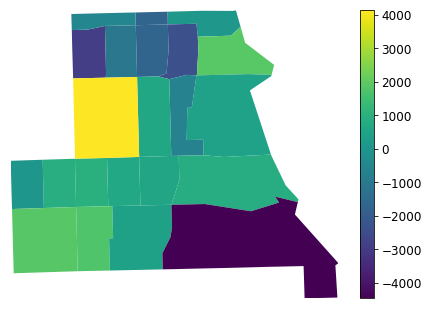

In [27]:
ax = tracts.plot(column = "nets_resid", legend = True)

map_format(ax)

So clearly I've missed a big chunk of South Shore, while the University (with very low population) is "over-represented" in terms of devices per household.

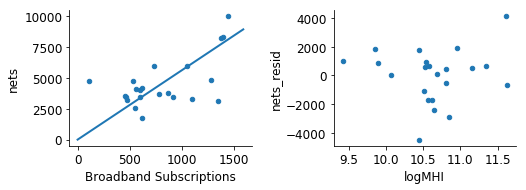

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (8, 2.5))

tracts_scalars.plot(kind = "scatter", x = "Broadband Subscriptions", y = "nets", ax = ax[0])

xmax = tracts_scalars["Broadband Subscriptions"].max() * 1.10

ax[0].plot([0, xmax], [0, xmax * slope])

tracts_scalars.plot(kind = "scatter", x = "logMHI", y = "nets_resid", ax = ax[1])

plt.subplots_adjust(wspace = 0.45)

In [29]:
tracts_scalars.corr().nets_resid.abs().sort_values(ascending = False)

nets_resid                 1.000000
Broadband Subscriptions    0.490506
nets_prop                  0.490506
Total Households           0.462291
nets                       0.409920
Total Pop                  0.230279
MHI                        0.203580
Broadband                  0.169797
BA                         0.159505
Hispanic                   0.104877
Black                      0.062082
logMHI                     0.060054
geoid                      0.019269
Name: nets_resid, dtype: float64